In [36]:
import hashlib
from PIL import Image
import io
import time
import os
import requests

In [37]:
from selenium import webdriver 
DRIVER_PATH = "C:/Users/wmm/Desktop/scraping/chromedriver"
wd = webdriver.Chrome(executable_path=DRIVER_PATH)

<ipython-input-37-26e5eba7cb5b>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  wd = webdriver.Chrome(executable_path=DRIVER_PATH)


In [38]:
wd.get('https://google.com')

In [39]:
search_box = wd.find_element_by_css_selector('input.gLFyf') 
search_box.send_keys('Dogs')

<ipython-input-39-bdd1307416b1>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_box = wd.find_element_by_css_selector('input.gLFyf')


In [40]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [41]:
def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [42]:
def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=150):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

In [43]:
search_term = 'cat'

search_and_download(
    search_term=search_term,
    driver_path=DRIVER_PATH)

<ipython-input-42-53759a3b3c8b>:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with webdriver.Chrome(executable_path=driver_path) as wd:
<ipython-input-40-6fae6806c786>:19: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")


Found: 100 search results. Extracting links from 0:100


<ipython-input-40-6fae6806c786>:33: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  actual_images = wd.find_elements_by_css_selector('img.n3VNCb')


Found: 150 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRopJ5Z5WIfx19Wo91IPJfLE-NRiOMS9qu8lw&usqp=CAU - as ./images\cat\7f0b418f72.jpg
SUCCESS - saved https://images2.minutemediacdn.com/image/upload/c_crop,h_1600,w_2378,x_11,y_0/v1628778532/shape/mentalfloss/87226-gettyimages-1247734973.jpg?itok=wNVO1JQG - as ./images\cat\f54352b4ff.jpg
SUCCESS - saved https://www.vets4pets.com/siteassets/species/cat/close-up-of-cat.jpg?width=1040 - as ./images\cat\b8bfbf8737.jpg
SUCCESS - saved https://media-cldnry.s-nbcnews.com/image/upload/newscms/2021_26/3487828/210630-stock-cat-bed-ew-245p.jpg - as ./images\cat\8546f44208.jpg
SUCCESS - saved https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png - as ./images\cat\4815f8dfaa.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQN9tafDg4xKQHivdzDZ3BWLcgYJqLdCSIp3w&usqp=CAU - as ./images\cat\18dd5448ab.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:A

In [23]:
import tensorflow as tf
import PIL
import random

In [24]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [25]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [26]:
dog_image_id = os.listdir('images/dogs')[0]
dog_image = load_image(os.path.join('images/dogs',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[3.87139742e-08, 8.98178532e-10, 2.19876628e-09, 9.39951894e-10,
        1.93474181e-10, 1.37576650e-09, 1.30338951e-09, 1.68800932e-06,
        4.52936092e-06, 4.61025351e-08, 1.88511451e-09, 2.64371164e-10,
        1.00046617e-10, 2.33160620e-08, 4.92444807e-10, 2.16089077e-07,
        1.00355564e-08, 1.01378301e-08, 3.76002646e-07, 1.15165157e-08,
        4.40855104e-08, 4.64791050e-08, 3.23376241e-07, 2.96595645e-05,
        3.15028444e-07, 2.66222655e-10, 3.15914739e-09, 6.96539217e-08,
        5.34833733e-09, 3.34356032e-09, 2.20409575e-08, 3.67159436e-09,
        1.20719434e-08, 7.06001702e-10, 5.18240206e-09, 5.13490583e-08,
        2.19268212e-08, 7.85268206e-09, 4.13869605e-09, 1.82944504e-09,
        4.82213425e-09, 2.09608131e-09, 4.28018154e-08, 5.32184217e-08,
        6.03638028e-08, 3.25873479e-08, 1.28062529e-08, 5.67500436e-10,
        2.06860349e-07, 2.77020860e-08, 2.84229191e-08, 4.88104268e-09,
        1.47089025e-08, 1.37342049e-08, 3.34697403e-09, 5.291797

In [27]:
model = tf.keras.applications.mobilenet.MobileNet(
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
x = Dropout(rate=0.4)(model.output)
x = Dense(3)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [29]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [30]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy'
)

In [31]:

from tensorflow.keras.applications import mobilenet as _mobilenet

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 171 images belonging to 1 classes.
Found 18 images belonging to 1 classes.


In [32]:
from keras_tqdm import TQDMNotebookCallback

batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
5/5 [==============================] - 6s 1s/step - loss: 5.4477
Epoch 2/10
5/5 [==============================] - 4s 831ms/step - loss: 5.7648
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 5.6496
Epoch 4/10
5/5 [==============================] - 5s 989ms/step - loss: 5.3346
Epoch 5/10
5/5 [==============================] - 4s 952ms/step - loss: 5.3734
Epoch 6/10
5/5 [==============================] - 4s 797ms/step - loss: 5.3717
Epoch 7/10
5/5 [==============================] - 4s 839ms/step - loss: 5.3710
Epoch 8/10
5/5 [==============================] - 4s 982ms/step - loss: 5.2315
Epoch 9/10
5/5 [==============================] - 5s 873ms/step - loss: 5.3869
Epoch 10/10
5/5 [==============================] - 4s 839ms/step - loss: 5.5210


KeyError: 'val_loss'

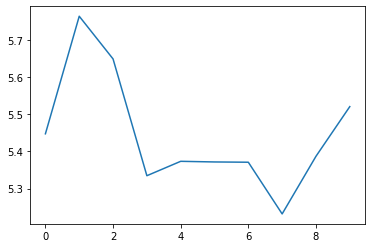

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
random_cat = random.choice(os.listdir('images/cat/'))
cat_path = os.path.join('images/cat',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir('images/dogs/'))
dog_path = os.path.join('images/dogs',random_dog)
dog = load_image(dog_path)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'images/cat/'

In [ ]:
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))

NameError: name 'tf' is not defined

In [ ]:
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))

NameError: name 'tf' is not defined